## attention和concatenate在feature engineering中的比较 21.11.25

### data-driven + attention feature engineering

In [ ]:
# 为loss function中的compare  21.11.25

### data-driven + concatenation feature engineering

In [1]:
# 一维离散小波变换，模型存储
# 对不同传感器信号采用不同的小波级数和频带，降低输入通道数 2020.10.24
# 运行环境 anaconda 1.10.0, python 3.8.5 tensorflow 2.4.0, numpy 1.19.2, pywt 1.1.1, matplotlib 3.3.2
# i5-8400 8GB
# LSTM + local attention + global attention
# train_data1， train_label1， test_data1， test_label1， physicsinformed1_model， physicsinformed1_model2表示physics-label one-hot

import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time
%load_ext tensorboard

from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.compat.v1.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config_proto = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
sess = tf.compat.v1.Session(config=config_proto)
set_session(sess)

file_index = 8
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径
SUMMARY_PATH = 'logs'     #记录路径

DOCUMENT_RESULT_PATH = 'results/comparation/feature engineering/'+str(file_index)+'/'
MODEL_SAVE_PATH = DOCUMENT_RESULT_PATH + 'concate_model.h5'

#信号层级关系
SIGNAL_LENGTH_1 = 1536
SIGNAL_LENGTH_2 = 64
SIGNAL_LENGTH_3 = 8

#输入数据
INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
INPUT_NUM = INPUT_SIZE[1]

SCALE_NUM_FORCE = 3 #小波分解级数
WAVELET_HIGHFREQ = 'db2'
WAVELET_LOWFREQ = 'db6'
# NOISE_FILTER_PERCENT = 90

LOWFREQ_INPUT_SIZE = [int(SIGNAL_LENGTH_1/8), 3]
LOWFREQ_LSTM_SIZE = 13
LOWFREQ_FEATURE_SIZE = 15
ATTENTION_SIZE = 18

HIGHFREQ_INPUT_SIZE = [SIGNAL_LENGTH_1, 3]
HIGHFREQ_LSTM_SIZE = 15
# LOWFREQ_FEATURE_SIZE = ATTENTION_SIZE
ATTENTION_RANGE = 24
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])
SAMPLING_STEP = LOWFREQ_INPUT_SIZE[0]//SIGNAL_LENGTH_2

PHYSICS_INPUT_SIZE =6 #输入local的物理条件[拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
PHYSICS_CONCATE1_SIZE = 18 #作为query的输入，包括物理条件和信号的均值和方差
LOCAL_INPUT_SIZE = [SIGNAL_LENGTH_2, LOWFREQ_FEATURE_SIZE+ATTENTION_SIZE]
LOCAL_TIMESTEP = SIGNAL_LENGTH_2//SIGNAL_LENGTH_3

LOCAL_DENSE_SIZE1 = 10
LOCAL_DENSE_SIZE2 = 25

GLOBAL_INPUT_SIZE = [SIGNAL_LENGTH_3, LOCAL_DENSE_SIZE1+LOCAL_DENSE_SIZE2]
GLOBAL_LSTM_SIZE = 25
GLOBAL_DENSE_SIZE1 = 10
GLOBAL_DENSE_SIZE2 = 36

PHYSICS_RESHAPE_SIZE = [6, 6]
PHYSICS_ATT_SIZE = 20
WEAR_DENSE_SIZE = 150
WEAR_SIZE = 1
LIFE_DENSE_SIZE = 80
LIFE_SIZE = 1

BATCH_SIZE = 64
PREDICTOR_TRAIN_BATCH = 6

learning_rate = np.array([1, 0.3, 0.1, 0.8, 0.27, 0.1, 
                 0.64, 0.24, 0.1, 0.51, 0.22, 0.1,
                 0.41, 0.20, 0.1, 0.33, 0.18, 0.1,
                 0.26, 0.16, 0.1])*0.01

weight_rate = np.array([0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 
                        0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 
                        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 
                        0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    
######################################################## 数据集构建 #######################################################################
# X_train [样本总量，样本长度，信号维度]
# Y_train [磨损标签，拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
X_train_set=np.load(TRAINDATA_LOADPATH)
Y_train_set = np.load(TRAINLABEL_LOADPATH)
Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
X_test_set=np.load(TESTDATA_LOADPATH)
Y_test_set = np.load(TESTLABEL_LOADPATH)
Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

#validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]
PHY_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]

X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]
PHY_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]

print('X_train', np.shape(X_train), np.min(X_train), np.max(X_train))
print('PHY_train', np.shape(PHY_train), np.min(PHY_train, axis=0), np.max(PHY_train, axis=0))
print('Y_train', np.shape(Y_train), np.min(Y_train), np.max(Y_train))
print('X_test', np.shape(X_test))
print('PHY_test', np.shape(PHY_test))
print('Y_test', np.shape(Y_test))

################################################ 小波分析 ####################################################################################
def wavelet_transform(data, scale_num):
    coeffs = np.arange(2).tolist()
    for j in range(np.shape(data)[2]):
        sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
        coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
        coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
        coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
        coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
#         for i in range(1, scale_num+1):       #高频去噪
#             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
        coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)
        
        if j == 0:
            coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
            coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
        else:
            coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
            coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
    return coeffs

coeffs_train_force = wavelet_transform(X_train, SCALE_NUM_FORCE)
coeffs_lowfreq_train = coeffs_train_force[0]
coeffs_highfreq_train = coeffs_train_force[1]
print('coeffs_lowfreq_train', np.shape(coeffs_lowfreq_train), np.min(coeffs_lowfreq_train), np.max(coeffs_lowfreq_train))
print('coeffs_highfreq_train', np.shape(coeffs_highfreq_train), np.min(coeffs_highfreq_train), np.max(coeffs_highfreq_train))

coeffs_test_force = wavelet_transform(X_test, SCALE_NUM_FORCE)
coeffs_lowfreq_test = coeffs_test_force[0]
coeffs_highfreq_test = coeffs_test_force[1]
print('coeffs_lowfreq_test', np.shape(coeffs_lowfreq_test), np.min(coeffs_lowfreq_test), np.max(coeffs_lowfreq_test))
print('coeffs_highfreq_test', np.shape(coeffs_highfreq_test), np.min(coeffs_highfreq_test), np.max(coeffs_highfreq_test))

######################################################### 模型搭建 ##################################################################
def mean_input_layer(x):#将输入的均值与预测器的特征拼接
    y = backend.mean(x, axis = 1, keepdims=True)
    y = backend.reshape(y, [BATCH_SIZE, SCALE_NUM_FORCE])
    return y
def var_input_layer(x):#将输入的方差与预测器的特征拼接
    y = backend.var(x, axis = 1, keepdims=True)
    y = backend.reshape(y, [BATCH_SIZE, SCALE_NUM_FORCE])
    return y

def lowfreq_model_construct(input_size, rnn_size, output_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='lowfreq_inputs')
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)
    x = layers.Lambda(lambda x: x[:, ::ATTENTION_RANGE//8])(x)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
    outputs = layers.TimeDistributed(layers.Dense(output_size))(x)
    outputs = layers.BatchNormalization(trainable=False)(outputs)
#     outputs = layers.BatchNormalization()(outputs)
    outputs = layers.LeakyReLU()(outputs)
    query = layers.TimeDistributed(layers.Dense(attention_size))(x)
    query = layers.LayerNormalization(axis = 1)(query)
    query = layers.LeakyReLU()(query)
    model_lowfreq = models.Model(inputs=inputs, outputs=[outputs, query], name = name)
    return model_lowfreq

def highfreq_model_construct(input_size, rnn_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='highfreq_inputs')
#     x = layers.Lambda(adjust_range, name = 'adjust_range')(inputs)
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)#, recurrent_regularizer=regularizers.l1(0.000001)
    key = layers.TimeDistributed(layers.Dense(attention_size))(x)
    key = layers.LayerNormalization(axis = 1)(key)
    key = layers.LeakyReLU()(key)
    value = layers.TimeDistributed(layers.Dense(attention_size))(x)
    value = layers.LayerNormalization(axis = 1)(value)
    value = layers.LeakyReLU()(value)
    model_highfreq = models.Model(inputs=inputs, outputs=[key, value], name = name)
    return model_highfreq

class lowhigh_freq_Attention(layers.Layer):
    # 将query，value和key拼接后输入，dot attention，便于timedistributed
    # https://blog.csdn.net/qq_37285386/article/details/101697758
    def __init__(self, **kwargs): #初始化方法
        super(lowhigh_freq_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
    def build(self, input_shape): #为Mylayer建立一个可训练的权重
        super(lowhigh_freq_Attention,self).build(input_shape)
    def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
        value = x[:, 1:ATTENTION_RANGE+1]
        key = x[:, ATTENTION_RANGE+1:]
#         print('query', np.shape(query), 'key', np.shape(key), 'value', np.shape(value))
        scores = tf.matmul(query, key, transpose_b=True)
#         print('scores', np.shape(scores))
        distribution = tf.nn.softmax(scores, axis = 2)
#         print('distribution', np.shape(distribution))
        value_weighted = tf.matmul(distribution, value)
#         print('value_weighted1', np.shape(value_weighted))
        value_weighted = tf.reduce_sum(value_weighted, axis=1)
#         print('value_weighted2', np.shape(value_weighted))
        attention_distribution = tf.squeeze(distribution)
#         print('attention_distribution', np.shape(attention_distribution))
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape
    
class temporal_Attention(layers.Layer):
    # 将query，value和key拼接后输入，dot attention，便于timedistributed
    # https://blog.csdn.net/qq_37285386/article/details/101697758
    def __init__(self, **kwargs): #初始化方法
        super(temporal_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
    def build(self, input_shape): #为Mylayer建立一个可训练的权重
        super(temporal_Attention,self).build(input_shape)
        self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
    def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
        key = x
        scores = tf.matmul(self.u_query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores, axis = 2)
        value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
        attention_distribution = tf.squeeze(distribution)
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])#这里是自己手动计算出来的output_shape
    
def localLSTM_construct(input_size, physics_size, timestep, dense_size1, dense_size2, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='inputs')
    inputs_query = layers.Input(shape=physics_size, batch_size = BATCH_SIZE, name='inputs_query')
    query = layers.Dense(dense_size1)(inputs_query)
    query = layers.LeakyReLU()(query)
    query = layers.RepeatVector(64)(query)
    query = layers.Reshape([8, 8, dense_size1])(query)
    x = layers.TimeDistributed(layers.Dense(dense_size2))(inputs)
    x = layers.Reshape([int(input_size[0]/timestep), timestep, dense_size2])(x)
    x = layers.LayerNormalization(axis = 2)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Concatenate(axis = 3)([query, x])    
    outputs, att_distribution_local = layers.TimeDistributed(temporal_Attention())(x)
    biLSTM_model = models.Model(inputs=[inputs, inputs_query], outputs=[outputs, att_distribution_local], name = name)
    return biLSTM_model

def globalLSTM_construct(input_size, physics_size, dense_size1, dense_size2, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='inputs')
    inputs_query = layers.Input(shape=physics_size, batch_size = BATCH_SIZE, name='inputs_query')
    query = layers.Dense(dense_size1)(inputs_query)
    query = layers.LeakyReLU()(query)
    query = layers.RepeatVector(8)(query)
    print('queryquery', np.shape(query))
    x = layers.TimeDistributed(layers.Dense(dense_size2))(inputs)
    x = layers.LayerNormalization(axis = 1)(x)
    x = layers.LeakyReLU()(x)
    print('xxxxx', np.shape(x))
    x = layers.Concatenate(axis = 2)([query, x])
    outputs, att_distribution_global = temporal_Attention()(x)
    biLSTM_model = models.Model(inputs=[inputs, inputs_query], outputs=[outputs, att_distribution_global], name = name)
    return biLSTM_model

#这里将物理模型的输出与信号的平均值和方差作为提示特征
#低频
input_lowfreq = layers.Input(shape=LOWFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_lowfreq')
mean_lowfreq = layers.Lambda(mean_input_layer, name = 'mean_lowfreq')(input_lowfreq)
var_lowfreq = layers.Lambda(var_input_layer, name = 'var_lowfreq')(input_lowfreq)
# input_lowfreq1 = layers.BatchNormalization()(input_lowfreq)
input_lowfreq1 = layers.BatchNormalization(trainable=False)(input_lowfreq)
#高频
input_highfreq = layers.Input(shape=HIGHFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_highfreq')
mean_highfreq = layers.Lambda(mean_input_layer, name = 'mean_highfreq')(input_highfreq)
var_highfreq = layers.Lambda(var_input_layer, name = 'var_highfreq')(input_highfreq)
input_highfreq1 = layers.BatchNormalization(trainable=False)(input_highfreq)
# input_highfreq1 = layers.BatchNormalization()(input_highfreq)
#提示特征
input_physics = layers.Input(shape=PHYSICS_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_physics')
print('mean_lowfreq', np.shape(mean_lowfreq), 'mean_highfreq', np.shape(mean_highfreq), 'input_physics', np.shape(input_physics))
input_physics1 = layers.Concatenate(axis = 1)([mean_lowfreq, var_lowfreq, mean_highfreq, var_highfreq, input_physics])#提示特征
# print('input_physics1', np.shape(input_physics1))

model_lowfreq = lowfreq_model_construct(LOWFREQ_INPUT_SIZE, LOWFREQ_LSTM_SIZE, LOWFREQ_FEATURE_SIZE, ATTENTION_SIZE, 'lowfreq_model')
model_highfreq = highfreq_model_construct(HIGHFREQ_INPUT_SIZE, HIGHFREQ_LSTM_SIZE, ATTENTION_SIZE, 'highfreq_model')
# 低频特征构造query，高频特征构造key和value，构建低频特征向高频特征的注意力模型，使高低频长度一致并对齐
feature_lowfreq, query = model_lowfreq(input_lowfreq1)
# feature_lowfreq = layers.Lambda(lambda x: x[:, ::6])(feature_lowfreq)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
# query = layers.Lambda(lambda x: x[:, ::6])(query)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
key, value = model_highfreq(input_highfreq1)

#高低频注意力机制
query = layers.Reshape([-1, 1, ATTENTION_SIZE])(query)
value = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(value)
key = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(key)
concate_vector = layers.Concatenate(axis = 2)([query, value, key])
feature_highfreq, att_distribution_lowhigh = layers.TimeDistributed(lowhigh_freq_Attention())(concate_vector)
# feature_highfreq = layers.BatchNormalization()(feature_highfreq)
feature_highfreq = layers.BatchNormalization(trainable=False)(feature_highfreq)
feature_freq = layers.Concatenate(axis = 2)([feature_lowfreq, feature_highfreq])
print('feature_freq', np.shape(feature_freq))

#local attention
biLSTM_local = localLSTM_construct(LOCAL_INPUT_SIZE, PHYSICS_CONCATE1_SIZE, LOCAL_TIMESTEP, 
                                   LOCAL_DENSE_SIZE1, LOCAL_DENSE_SIZE2, 'biLSTM_local')
feature_local, att_distribution_local = biLSTM_local([feature_freq, input_physics1])
feature_local = layers.BatchNormalization(trainable=False)(feature_local)
# feature_local = layers.BatchNormalization()(feature_local)
print('feature_local', feature_local)

#global attention
biLSTM_global = globalLSTM_construct(GLOBAL_INPUT_SIZE, PHYSICS_CONCATE1_SIZE, GLOBAL_DENSE_SIZE1, 
                                     GLOBAL_DENSE_SIZE2, 'biLSTM_global')
feature, att_distribution_global = biLSTM_global([feature_local, input_physics1])
print('feature', np.shape(feature))

#physics dense
physics_feature = layers.Concatenate()([feature, input_physics1])
# physics_feature = layers.Concatenate()([feature, input_physics])

#tool wear predict
x = layers.Dense(WEAR_DENSE_SIZE)(physics_feature)
x = layers.BatchNormalization(trainable=False)(x)
# x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
wear_predict = layers.Dense(WEAR_SIZE, activation = 'sigmoid', name='wear_predict')(x)

predictor = models.Model(inputs=[input_lowfreq, input_highfreq, input_physics], 
                         outputs=wear_predict, name='tool_wear_predictor')
predictor.summary()

#############################################模型训练#########################################################################
time_start = time.time()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=SUMMARY_PATH, histogram_freq=1)
checkpoint = keras.callbacks.ModelCheckpoint(MODEL_SAVE_PATH, monitor='wear_predict',  save_best_only=True, mode='max')
for i in range(PREDICTOR_TRAIN_BATCH):
    print('##########'+str(i+1)+'############')
    adam = keras.optimizers.Adam(lr=learning_rate[i])
    predictor.compile(optimizer=adam, loss = 'mse')
    history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train, PHY_train[:, :-1]], Y_train, batch_size=BATCH_SIZE, 
                            validation_data = ([coeffs_lowfreq_test, coeffs_highfreq_test, PHY_test[:, :-1]], Y_test), 
                            epochs=1,  shuffle=True, verbose=1, callbacks=[tensorboard_callback, checkpoint])
    
predictor.save(MODEL_SAVE_PATH)
print('time1 =  ', time.time()-time_start)

X_train (9728, 1536, 3) -0.9293552041053772 0.8662327527999878
PHY_train (9728, 7) [1.8072429e-01 6.0000002e-01 6.0000002e-01 3.3333334e-01 2.0000000e-01
 2.0000000e-01 3.8910506e-04] [0.863643   1.         1.         1.         1.         1.
 0.99833196]
Y_train (9728,) 0.18163076 0.87186223
X_test (1088, 1536, 3)
PHY_test (1088, 7)
Y_test (1088,)
coeffs_lowfreq_train (9728, 192, 3) -1.6887109675302232 1.6770890508760357
coeffs_highfreq_train (9728, 1536, 3) -0.6074406355435511 0.6436477411157987
coeffs_lowfreq_test (1088, 192, 3) -1.5425268591451757 1.6827855264342724
coeffs_highfreq_test (1088, 1536, 3) -0.8581441584885379 0.6740121754985141
mean_lowfreq (64, 3) mean_highfreq (64, 3) input_physics (64, 6)
feature_freq (64, 64, 33)
feature_local KerasTensor(type_spec=TensorSpec(shape=(64, 8, 35), dtype=tf.float32, name=None), name='batch_normalization_4/batchnorm/add_1:0', description="created by layer 'batch_normalization_4'")
queryquery (64, 8, 10)
xxxxx (64, 8, 36)
feature (64, 46

##########3############
152/152 [==============================] - 76s 454ms/step - loss: 4.0724e-04 - val_loss: 0.0010
##########4############
152/152 [==============================] - 78s 464ms/step - loss: 0.0030 - val_loss: 0.0011
##########5############
152/152 [==============================] - 79s 467ms/step - loss: 7.1454e-04 - val_loss: 0.0010
##########6############
152/152 [==============================] - 80s 473ms/step - loss: 3.2756e-04 - val_loss: 0.0010
time1 =   474.69678711891174


wear_pre_train (9408, 1)
loss_train_avg 0.00019447238
percent_train_avg 2.424526773393154 %
time1 =   2.634999990463257 sample_num 1408
loss_test_avg 0.0013301248
percent_test_avg 6.71045184135437 %


<Figure size 1080x432 with 0 Axes>

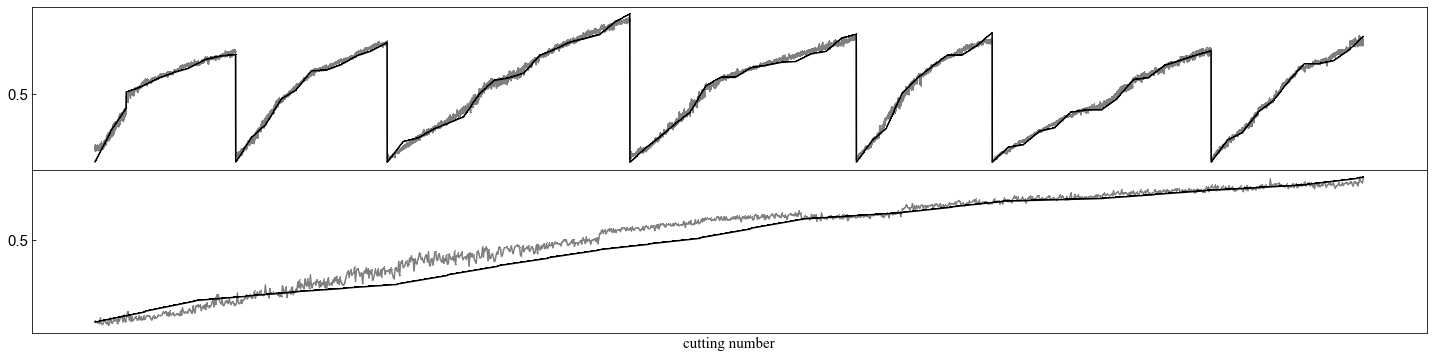

In [4]:
#
import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time

file_index = 4
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径

DOCUMENT_RESULT_PATH = 'results/comparation/feature engineering/'+str(file_index)+'/'
MODEL_LOAD_PATH = DOCUMENT_RESULT_PATH + 'concate_model.h5'
PHYSICINFOMED_SAVEPATH = DOCUMENT_RESULT_PATH + 'concate_result.npy'
    
load_flag = 1 ########################################1:重新加载模型，0：不加载##########################

if load_flag == 1:
    #信号层级关系
    SIGNAL_LENGTH_1 = 1536
    SIGNAL_LENGTH_2 = 64
    SIGNAL_LENGTH_3 = 8

    #输入数据
    INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
    INPUT_NUM = INPUT_SIZE[1]
    SCALE_NUM_FORCE = 3 #小波分解级数
    WAVELET_HIGHFREQ = 'db2'
    WAVELET_LOWFREQ = 'db6'
    # NOISE_FILTER_PERCENT = 90
    ATTENTION_RANGE = 24
    WEAR_SIZE = 1
    LIFE_SIZE = 1
    BATCH_SIZE = 64

    def wavelet_transform(data, scale_num):
        coeffs = np.arange(2).tolist()
        for j in range(np.shape(data)[2]):
            sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
            coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
            coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
            coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
            coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
    #         for i in range(1, scale_num+1):       #高频去噪
    #             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
            coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)

            if j == 0:
                coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
                coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
            else:
                coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
                coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
        return coeffs

    class lowhigh_freq_Attention(layers.Layer):
        # 将query，value和key拼接后输入，dot attention，便于timedistributed
        # https://blog.csdn.net/qq_37285386/article/details/101697758
        def __init__(self, **kwargs): #初始化方法
            super(lowhigh_freq_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
        def build(self, input_shape): #为Mylayer建立一个可训练的权重
            super(lowhigh_freq_Attention,self).build(input_shape)
        def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
            query = x[:, 0]
            query = tf.expand_dims(query, axis=1)
            value = x[:, 1:ATTENTION_RANGE+1]
            key = x[:, ATTENTION_RANGE+1:]
    #         print('query', np.shape(query), 'key', np.shape(key), 'value', np.shape(value))
            scores = tf.matmul(query, key, transpose_b=True)
    #         print('scores', np.shape(scores))
            distribution = tf.nn.softmax(scores, axis = 2)
    #         print('distribution', np.shape(distribution))
            value_weighted = tf.matmul(distribution, value)
    #         print('value_weighted1', np.shape(value_weighted))
            value_weighted = tf.reduce_sum(value_weighted, axis=1)
    #         print('value_weighted2', np.shape(value_weighted))
            attention_distribution = tf.squeeze(distribution)
    #         print('attention_distribution', np.shape(attention_distribution))
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape

    class temporal_Attention(layers.Layer):
        # 将query，value和key拼接后输入，dot attention，便于timedistributed
        # https://blog.csdn.net/qq_37285386/article/details/101697758
        def __init__(self, **kwargs): #初始化方法
            super(temporal_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
        def build(self, input_shape): #为Mylayer建立一个可训练的权重
            super(temporal_Attention,self).build(input_shape)
            self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
        def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
            key = x
            scores = tf.matmul(self.u_query, key, transpose_b=True)
            distribution = tf.nn.softmax(scores, axis = 2)
            value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
            attention_distribution = tf.squeeze(distribution)
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])#这里是自己手动计算出来的output_shape

    X_train_set=np.load(TRAINDATA_LOADPATH)
    Y_train_set = np.load(TRAINLABEL_LOADPATH)
    Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
    X_test_set=np.load(TESTDATA_LOADPATH)
    Y_test_set = np.load(TESTLABEL_LOADPATH)
    Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

    #validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
    X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
    Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]
    PHY_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
    X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
    Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]
    PHY_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]

    coeffs_train_force = wavelet_transform(X_train, SCALE_NUM_FORCE)
    coeffs_lowfreq_train = coeffs_train_force[0]
    coeffs_highfreq_train = coeffs_train_force[1]
    coeffs_test_force = wavelet_transform(X_test, SCALE_NUM_FORCE)
    coeffs_lowfreq_test = coeffs_test_force[0]
    coeffs_highfreq_test = coeffs_test_force[1]  

    ################################################### 模型读取及预测 ##################################################
    predictor = keras.models.load_model(MODEL_LOAD_PATH, custom_objects={'lowhigh_freq_Attention':lowhigh_freq_Attention, 
                                                                         'temporal_Attention':temporal_Attention})

################################################### 波形显示 ##################################################
fig_x = 15
fig_y = 6
size = 15
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
font1 = {'family':'Times New Roman', 'weight':'normal', 'size':size}

#train
wear_pre_train = predictor.predict([coeffs_lowfreq_train, coeffs_highfreq_train, PHY_train[:, :-1]], batch_size = BATCH_SIZE)
print('wear_pre_train', np.shape(wear_pre_train))

axis = np.linspace(1, np.shape(wear_pre_train)[0], np.shape(wear_pre_train)[0])
print('loss_train_avg', np.mean(np.square(wear_pre_train[:, 0] - Y_train)))
print('percent_train_avg', np.mean(np.abs(wear_pre_train[:, 0] - Y_train)/Y_train)*100, '%')
plt.figure(figsize=(25, 6))
plt.subplots_adjust(wspace=0, hspace=0)
plt.subplot(2,1,1)
plt.xticks([])  #去掉纵坐标值
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
plt.yticks([0.0, 0.5, 1], fontproperties = 'Times New Roman', size = size)   
plt.plot(axis, wear_pre_train[:, 0], marker = ',', color = 'gray')
plt.plot(axis, Y_train, marker = ',', color = 'black')

#test
# score = predictor.evaluate([coeffs_lowfreq_test, coeffs_highfreq_test, PHY_test], Y_test, verbose=0, batch_size = BATCH_SIZE)
time_start = time.time()
wear_pre_test = predictor.predict([coeffs_lowfreq_test, coeffs_highfreq_test, PHY_test[:, :-1]], batch_size = BATCH_SIZE)
print('time1 =  ', time.time()-time_start, 'sample_num', np.shape(coeffs_lowfreq_test)[0])

axis = np.linspace(1, np.shape(wear_pre_test)[0], np.shape(wear_pre_test)[0])
print('loss_test_avg', np.mean(np.square(wear_pre_test[:, 0] - Y_test)))
print('percent_test_avg', np.mean(np.abs(wear_pre_test[:, 0] - Y_test)/Y_test)*100, '%')
plt.subplot(2,1,2)
plt.xticks([])  #去掉纵坐标值
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
plt.yticks([0.0, 0.5, 1], fontproperties = 'Times New Roman', size = size)   
plt.plot(axis, wear_pre_test[:, 0], marker = ',', color = 'gray')
plt.plot(axis, Y_test, marker = ',', color = 'black')
# plt.savefig(DOCUMENT_RESULT_PATH + 'test_output.eps')
plt.show()

np.save(PHYSICINFOMED_SAVEPATH, wear_pre_test[:, 0])

### data-driven + 1-layer attention

In [ ]:
# 一维离散小波变换，模型存储
# 对不同传感器信号采用不同的小波级数和频带，降低输入通道数 2020.10.24
# 运行环境 anaconda 1.10.0, python 3.8.5 tensorflow 2.4.0, numpy 1.19.2, pywt 1.1.1, matplotlib 3.3.2
# i5-8400 8GB
# LSTM + local attention + global attention
# train_data1， train_label1， test_data1， test_label1， physicsinformed1_model， physicsinformed1_model2表示physics-label one-hot

import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time
%load_ext tensorboard

from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.compat.v1.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config_proto = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
sess = tf.compat.v1.Session(config=config_proto)
set_session(sess)

file_index = 1
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径
SUMMARY_PATH = 'logs'     #记录路径

DOCUMENT_RESULT_PATH = 'results/comparation/feature engineering/'+str(file_index)+'/'
MODEL_SAVE_PATH = DOCUMENT_RESULT_PATH + '1_layer_attention_model.h5'

#信号层级关系
SIGNAL_LENGTH_1 = 1536
SIGNAL_LENGTH_2 = 64
SIGNAL_LENGTH_3 = 8

#输入数据
INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
INPUT_NUM = INPUT_SIZE[1]

SCALE_NUM_FORCE = 3 #小波分解级数
WAVELET_HIGHFREQ = 'db2'
WAVELET_LOWFREQ = 'db6'
# NOISE_FILTER_PERCENT = 90

LOWFREQ_INPUT_SIZE = [int(SIGNAL_LENGTH_1/8), 3]
LOWFREQ_LSTM_SIZE = 13
LOWFREQ_FEATURE_SIZE = 15
ATTENTION_SIZE = 18

HIGHFREQ_INPUT_SIZE = [SIGNAL_LENGTH_1, 3]
HIGHFREQ_LSTM_SIZE = 15
# LOWFREQ_FEATURE_SIZE = ATTENTION_SIZE
ATTENTION_RANGE = 24
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])
SAMPLING_STEP = LOWFREQ_INPUT_SIZE[0]//SIGNAL_LENGTH_2

PHYSICS_INPUT_SIZE =6 #输入local的物理条件[拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
PHYSICS_CONCATE1_SIZE = 18 #作为query的输入，包括物理条件和信号的均值和方差
LOCAL_INPUT_SIZE = [SIGNAL_LENGTH_2, LOWFREQ_FEATURE_SIZE+ATTENTION_SIZE]
LOCAL_TIMESTEP = SIGNAL_LENGTH_2//SIGNAL_LENGTH_3
LOCAL_DENSE_SIZE2 = 25

GLOBAL_INPUT_SIZE = [SIGNAL_LENGTH_3, LOCAL_DENSE_SIZE2]
GLOBAL_LSTM_SIZE = 25
GLOBAL_DENSE_SIZE = 36

PHYSICS_RESHAPE_SIZE = [6, 6]
PHYSICS_ATT_SIZE = 20
WEAR_DENSE_SIZE = 150
WEAR_SIZE = 1
LIFE_DENSE_SIZE = 80
LIFE_SIZE = 1

BATCH_SIZE = 64
PREDICTOR_TRAIN_BATCH = 6

learning_rate = np.array([1, 0.3, 0.1, 0.8, 0.27, 0.1, 
                 0.64, 0.24, 0.1, 0.51, 0.22, 0.1,
                 0.41, 0.20, 0.1, 0.33, 0.18, 0.1,
                 0.26, 0.16, 0.1])*0.01

weight_rate = np.array([0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 
                        0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 
                        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 
                        0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    
######################################################## 数据集构建 #######################################################################
# X_train [样本总量，样本长度，信号维度]
# Y_train [磨损标签，拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
X_train_set=np.load(TRAINDATA_LOADPATH)
Y_train_set = np.load(TRAINLABEL_LOADPATH)
Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
X_test_set=np.load(TESTDATA_LOADPATH)
Y_test_set = np.load(TESTLABEL_LOADPATH)
Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

#validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]
PHY_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]

X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]
PHY_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]

print('X_train', np.shape(X_train), np.min(X_train), np.max(X_train))
print('PHY_train', np.shape(PHY_train), np.min(PHY_train, axis=0), np.max(PHY_train, axis=0))
print('Y_train', np.shape(Y_train), np.min(Y_train), np.max(Y_train))
print('X_test', np.shape(X_test))
print('PHY_test', np.shape(PHY_test))
print('Y_test', np.shape(Y_test))

################################################ 小波分析 ####################################################################################
def wavelet_transform(data, scale_num):
    coeffs = np.arange(2).tolist()
    for j in range(np.shape(data)[2]):
        sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
        coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
        coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
        coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
        coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
#         for i in range(1, scale_num+1):       #高频去噪
#             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
        coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)
        
        if j == 0:
            coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
            coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
        else:
            coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
            coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
    return coeffs

coeffs_train_force = wavelet_transform(X_train, SCALE_NUM_FORCE)
coeffs_lowfreq_train = coeffs_train_force[0]
coeffs_highfreq_train = coeffs_train_force[1]
print('coeffs_lowfreq_train', np.shape(coeffs_lowfreq_train), np.min(coeffs_lowfreq_train), np.max(coeffs_lowfreq_train))
print('coeffs_highfreq_train', np.shape(coeffs_highfreq_train), np.min(coeffs_highfreq_train), np.max(coeffs_highfreq_train))

coeffs_test_force = wavelet_transform(X_test, SCALE_NUM_FORCE)
coeffs_lowfreq_test = coeffs_test_force[0]
coeffs_highfreq_test = coeffs_test_force[1]
print('coeffs_lowfreq_test', np.shape(coeffs_lowfreq_test), np.min(coeffs_lowfreq_test), np.max(coeffs_lowfreq_test))
print('coeffs_highfreq_test', np.shape(coeffs_highfreq_test), np.min(coeffs_highfreq_test), np.max(coeffs_highfreq_test))

######################################################### 模型搭建 ##################################################################
def mean_input_layer(x):#将输入的均值与预测器的特征拼接
    y = backend.mean(x, axis = 1, keepdims=True)
    y = backend.reshape(y, [BATCH_SIZE, SCALE_NUM_FORCE])
    return y
def var_input_layer(x):#将输入的方差与预测器的特征拼接
    y = backend.var(x, axis = 1, keepdims=True)
    y = backend.reshape(y, [BATCH_SIZE, SCALE_NUM_FORCE])
    return y

def lowfreq_model_construct(input_size, rnn_size, output_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='lowfreq_inputs')
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)
    x = layers.Lambda(lambda x: x[:, ::ATTENTION_RANGE//8])(x)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
    outputs = layers.TimeDistributed(layers.Dense(output_size))(x)
    outputs = layers.BatchNormalization(trainable=False)(outputs)
#     outputs = layers.BatchNormalization()(outputs)
    outputs = layers.LeakyReLU()(outputs)
    query = layers.TimeDistributed(layers.Dense(attention_size))(x)
    query = layers.LayerNormalization(axis = 1)(query)
    query = layers.LeakyReLU()(query)
    model_lowfreq = models.Model(inputs=inputs, outputs=[outputs, query], name = name)
    return model_lowfreq

def highfreq_model_construct(input_size, rnn_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='highfreq_inputs')
#     x = layers.Lambda(adjust_range, name = 'adjust_range')(inputs)
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)#, recurrent_regularizer=regularizers.l1(0.000001)
    key = layers.TimeDistributed(layers.Dense(attention_size))(x)
    key = layers.LayerNormalization(axis = 1)(key)
    key = layers.LeakyReLU()(key)
    value = layers.TimeDistributed(layers.Dense(attention_size))(x)
    value = layers.LayerNormalization(axis = 1)(value)
    value = layers.LeakyReLU()(value)
    model_highfreq = models.Model(inputs=inputs, outputs=[key, value], name = name)
    return model_highfreq

class lowhigh_freq_Attention(layers.Layer):
    # 将query，value和key拼接后输入，dot attention，便于timedistributed
    # https://blog.csdn.net/qq_37285386/article/details/101697758
    def __init__(self, **kwargs): #初始化方法
        super(lowhigh_freq_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
    def build(self, input_shape): #为Mylayer建立一个可训练的权重
        super(lowhigh_freq_Attention,self).build(input_shape)
    def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
        value = x[:, 1:ATTENTION_RANGE+1]
        key = x[:, ATTENTION_RANGE+1:]
#         print('query', np.shape(query), 'key', np.shape(key), 'value', np.shape(value))
        scores = tf.matmul(query, key, transpose_b=True)
#         print('scores', np.shape(scores))
        distribution = tf.nn.softmax(scores, axis = 2)
#         print('distribution', np.shape(distribution))
        value_weighted = tf.matmul(distribution, value)
#         print('value_weighted1', np.shape(value_weighted))
        value_weighted = tf.reduce_sum(value_weighted, axis=1)
#         print('value_weighted2', np.shape(value_weighted))
        attention_distribution = tf.squeeze(distribution)
#         print('attention_distribution', np.shape(attention_distribution))
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape
    
class temporal_Attention(layers.Layer):
    # 将query，value和key拼接后输入，dot attention，便于timedistributed
    # https://blog.csdn.net/qq_37285386/article/details/101697758
    def __init__(self, **kwargs): #初始化方法
        super(temporal_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
    def build(self, input_shape): #为Mylayer建立一个可训练的权重
        super(temporal_Attention,self).build(input_shape)
        self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
    def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
        key = x
        scores = tf.matmul(self.u_query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores, axis = 2)
        value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
        attention_distribution = tf.squeeze(distribution)
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])#这里是自己手动计算出来的output_shape
    
def localLSTM_construct(input_size, timestep, dense_size2, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='inputs')
    x = layers.TimeDistributed(layers.Dense(dense_size2))(inputs)
    x = layers.Reshape([int(input_size[0]/timestep), timestep, dense_size2])(x)
    x = layers.LayerNormalization(axis = 2)(x)
    x = layers.LeakyReLU()(x) 
    outputs, att_distribution_local = layers.TimeDistributed(temporal_Attention())(x)
    biLSTM_model = models.Model(inputs=inputs, outputs=[outputs, att_distribution_local], name = name)
    return biLSTM_model

def globalLSTM_construct(input_size, dense_size2, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='inputs')
    x = layers.TimeDistributed(layers.Dense(dense_size2))(inputs)
    x = layers.LayerNormalization(axis = 1)(x)
    x = layers.LeakyReLU()(x)
    outputs, att_distribution_global = temporal_Attention()(x)
    biLSTM_model = models.Model(inputs=inputs, outputs=[outputs, att_distribution_global], name = name)
    return biLSTM_model

def multiply_construct(input_feature_size, feature_reshape_size, input_physics_size, dense_att_size, name):
    inputs_feature = layers.Input(shape=input_feature_size, batch_size = BATCH_SIZE, name='inputs_feature')
    feature = layers.Reshape(feature_reshape_size)(inputs_feature)
    feature = layers.TimeDistributed(layers.Dense(dense_att_size, activation = 'tanh'))(feature)
    inputs_physics = layers.Input(shape=input_physics_size, batch_size = BATCH_SIZE, name='inputs_physics')
    physics = layers.Dense(dense_att_size, activation = 'tanh')(inputs_physics)
    physics = layers.Reshape([1, dense_att_size])(physics)
    outputs = layers.Attention(use_scale=False)([physics, feature])
    outputs = layers.Reshape([dense_att_size])(outputs)
    multiply_model = models.Model(inputs=[inputs_feature, inputs_physics], outputs=outputs, name = name)
    return multiply_model

#这里将物理模型的输出与信号的平均值和方差作为提示特征
#低频
input_lowfreq = layers.Input(shape=LOWFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_lowfreq')
mean_lowfreq = layers.Lambda(mean_input_layer, name = 'mean_lowfreq')(input_lowfreq)
var_lowfreq = layers.Lambda(var_input_layer, name = 'var_lowfreq')(input_lowfreq)
# input_lowfreq1 = layers.BatchNormalization()(input_lowfreq)
input_lowfreq1 = layers.BatchNormalization(trainable=False)(input_lowfreq)
#高频
input_highfreq = layers.Input(shape=HIGHFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_highfreq')
mean_highfreq = layers.Lambda(mean_input_layer, name = 'mean_highfreq')(input_highfreq)
var_highfreq = layers.Lambda(var_input_layer, name = 'var_highfreq')(input_highfreq)
input_highfreq1 = layers.BatchNormalization(trainable=False)(input_highfreq)
# input_highfreq1 = layers.BatchNormalization()(input_highfreq)
#提示特征
input_physics = layers.Input(shape=PHYSICS_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_physics')
print('mean_lowfreq', np.shape(mean_lowfreq), 'mean_highfreq', np.shape(mean_highfreq), 'input_physics', np.shape(input_physics))
input_physics1 = layers.Concatenate(axis = 1)([mean_lowfreq, var_lowfreq, mean_highfreq, var_highfreq, input_physics])#提示特征
# print('input_physics1', np.shape(input_physics1))

model_lowfreq = lowfreq_model_construct(LOWFREQ_INPUT_SIZE, LOWFREQ_LSTM_SIZE, LOWFREQ_FEATURE_SIZE, ATTENTION_SIZE, 'lowfreq_model')
model_highfreq = highfreq_model_construct(HIGHFREQ_INPUT_SIZE, HIGHFREQ_LSTM_SIZE, ATTENTION_SIZE, 'highfreq_model')
# 低频特征构造query，高频特征构造key和value，构建低频特征向高频特征的注意力模型，使高低频长度一致并对齐
feature_lowfreq, query = model_lowfreq(input_lowfreq1)
# feature_lowfreq = layers.Lambda(lambda x: x[:, ::6])(feature_lowfreq)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
# query = layers.Lambda(lambda x: x[:, ::6])(query)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
key, value = model_highfreq(input_highfreq1)

#高低频注意力机制
query = layers.Reshape([-1, 1, ATTENTION_SIZE])(query)
value = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(value)
key = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(key)
concate_vector = layers.Concatenate(axis = 2)([query, value, key])
feature_highfreq, att_distribution_lowhigh = layers.TimeDistributed(lowhigh_freq_Attention())(concate_vector)
# feature_highfreq = layers.BatchNormalization()(feature_highfreq)
feature_highfreq = layers.BatchNormalization(trainable=False)(feature_highfreq)
feature_freq = layers.Concatenate(axis = 2)([feature_lowfreq, feature_highfreq])
print('feature_freq', np.shape(feature_freq))

#local attention
biLSTM_local = localLSTM_construct(LOCAL_INPUT_SIZE, LOCAL_TIMESTEP, LOCAL_DENSE_SIZE2, 'biLSTM_local')
feature_local, att_distribution_local = biLSTM_local(feature_freq)
feature_local = layers.BatchNormalization(trainable=False)(feature_local)
# feature_local = layers.BatchNormalization()(feature_local)
print('feature_local', feature_local)

#global attention
biLSTM_global = globalLSTM_construct(GLOBAL_INPUT_SIZE, GLOBAL_DENSE_SIZE, 'biLSTM_global')
feature, att_distribution_global = biLSTM_global(feature_local)
print('feature', np.shape(feature))

#physics dense
multiply_physics = multiply_construct(GLOBAL_DENSE_SIZE, PHYSICS_RESHAPE_SIZE, PHYSICS_CONCATE1_SIZE, PHYSICS_ATT_SIZE, 'physics')
physics_feature = multiply_physics([feature, input_physics1])
physics_feature = layers.Reshape([PHYSICS_ATT_SIZE])(physics_feature)

#tool wear predict
x = layers.Dense(WEAR_DENSE_SIZE)(physics_feature)
x = layers.BatchNormalization(trainable=False)(x)
# x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
wear_predict = layers.Dense(WEAR_SIZE, activation = 'sigmoid', name='wear_predict')(x)

predictor = models.Model(inputs=[input_lowfreq, input_highfreq, input_physics], 
                         outputs=wear_predict, name='tool_wear_predictor')
predictor.summary()

#############################################模型训练#########################################################################
time_start = time.time()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=SUMMARY_PATH, histogram_freq=1)
checkpoint = keras.callbacks.ModelCheckpoint(MODEL_SAVE_PATH, monitor='wear_predict',  save_best_only=True, mode='max')
for i in range(PREDICTOR_TRAIN_BATCH):
    print('##########'+str(i+1)+'############')
    adam = keras.optimizers.Adam(lr=learning_rate[i])
    predictor.compile(optimizer=adam, loss = 'mse')
    history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train, PHY_train[:, :-1]], Y_train, batch_size=BATCH_SIZE, 
                            validation_data = ([coeffs_lowfreq_test, coeffs_highfreq_test, PHY_test[:, :-1]], Y_test), 
                            epochs=1,  shuffle=True, verbose=1, callbacks=[tensorboard_callback, checkpoint])
    
predictor.save(MODEL_SAVE_PATH)
print('time1 =  ', time.time()-time_start)

X_train (9792, 1536, 3) -1.0226240158081055 0.8822135925292969
PHY_train (9792, 7) [1.8094027e-01 6.0000002e-01 6.0000002e-01 3.3333334e-01 2.6666668e-01
 2.0000000e-01 3.8910506e-04] [0.863643   1.         1.         1.         1.         0.7411765
 0.74874896]
Y_train (9792,) 0.18163076 0.87186223
X_test (1024, 1536, 3)
PHY_test (1024, 7)
Y_test (1024,)
coeffs_lowfreq_train (9792, 192, 3) -1.6887109675302232 1.6827855264342724
coeffs_highfreq_train (9792, 1536, 3) -0.8882813551840282 0.7132884507306377
coeffs_lowfreq_test (1024, 192, 3) -1.4341723166027973 1.6138990016487686
coeffs_highfreq_test (1024, 1536, 3) -0.4703053545347131 0.4908650818103628
mean_lowfreq (64, 3) mean_highfreq (64, 3) input_physics (64, 6)
feature_freq (64, 64, 33)
feature_local KerasTensor(type_spec=TensorSpec(shape=(64, 8, 25), dtype=tf.float32, name=None), name='batch_normalization_4/batchnorm/add_1:0', description="created by layer 'batch_normalization_4'")
feature (64, 36)
Model: "tool_wear_predictor"
___

wear_pre_train (9728, 1)
loss_train_avg 0.00020320479
percent_train_avg 2.483966201543808 %
time1 =   2.066075086593628 sample_num 1088
loss_test_avg 0.001389485
percent_test_avg 6.226065754890442 %


<Figure size 1080x432 with 0 Axes>

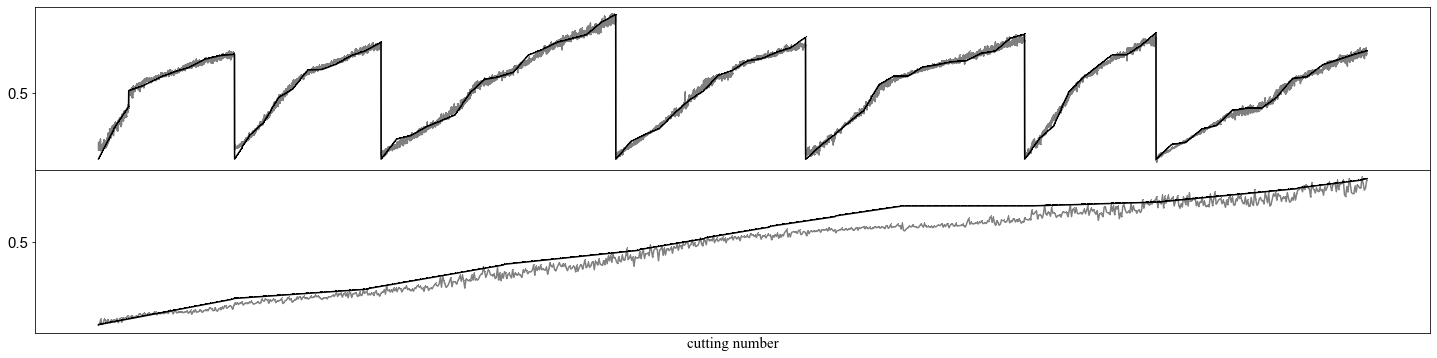

In [10]:
#
import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time

file_index = 8
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径

DOCUMENT_RESULT_PATH = 'results/comparation/feature engineering/'+str(file_index)+'/'
MODEL_LOAD_PATH = DOCUMENT_RESULT_PATH + '1_layer_attention_model.h5'
PHYSICINFOMED_SAVEPATH = DOCUMENT_RESULT_PATH + '1_layer_attention_result.npy'
    
load_flag = 1 ########################################1:重新加载模型，0：不加载##########################

if load_flag == 1:
    #信号层级关系
    SIGNAL_LENGTH_1 = 1536
    SIGNAL_LENGTH_2 = 64
    SIGNAL_LENGTH_3 = 8

    #输入数据
    INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
    INPUT_NUM = INPUT_SIZE[1]
    SCALE_NUM_FORCE = 3 #小波分解级数
    WAVELET_HIGHFREQ = 'db2'
    WAVELET_LOWFREQ = 'db6'
    # NOISE_FILTER_PERCENT = 90
    ATTENTION_RANGE = 24
    WEAR_SIZE = 1
    LIFE_SIZE = 1
    BATCH_SIZE = 64

    def wavelet_transform(data, scale_num):
        coeffs = np.arange(2).tolist()
        for j in range(np.shape(data)[2]):
            sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
            coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
            coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
            coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
            coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
    #         for i in range(1, scale_num+1):       #高频去噪
    #             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
            coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)

            if j == 0:
                coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
                coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
            else:
                coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
                coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
        return coeffs

    class lowhigh_freq_Attention(layers.Layer):
        # 将query，value和key拼接后输入，dot attention，便于timedistributed
        # https://blog.csdn.net/qq_37285386/article/details/101697758
        def __init__(self, **kwargs): #初始化方法
            super(lowhigh_freq_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
        def build(self, input_shape): #为Mylayer建立一个可训练的权重
            super(lowhigh_freq_Attention,self).build(input_shape)
        def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
            query = x[:, 0]
            query = tf.expand_dims(query, axis=1)
            value = x[:, 1:ATTENTION_RANGE+1]
            key = x[:, ATTENTION_RANGE+1:]
    #         print('query', np.shape(query), 'key', np.shape(key), 'value', np.shape(value))
            scores = tf.matmul(query, key, transpose_b=True)
    #         print('scores', np.shape(scores))
            distribution = tf.nn.softmax(scores, axis = 2)
    #         print('distribution', np.shape(distribution))
            value_weighted = tf.matmul(distribution, value)
    #         print('value_weighted1', np.shape(value_weighted))
            value_weighted = tf.reduce_sum(value_weighted, axis=1)
    #         print('value_weighted2', np.shape(value_weighted))
            attention_distribution = tf.squeeze(distribution)
    #         print('attention_distribution', np.shape(attention_distribution))
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape
    
    class temporal_Attention(layers.Layer):
        # 将query，value和key拼接后输入，dot attention，便于timedistributed
        # https://blog.csdn.net/qq_37285386/article/details/101697758
        def __init__(self, **kwargs): #初始化方法
            super(temporal_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
        def build(self, input_shape): #为Mylayer建立一个可训练的权重
            super(temporal_Attention,self).build(input_shape)
            self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
        def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
            key = x
            scores = tf.matmul(self.u_query, key, transpose_b=True)
            distribution = tf.nn.softmax(scores, axis = 2)
            value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
            attention_distribution = tf.squeeze(distribution)
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])#这里是自己手动计算出来的output_shape

    X_train_set=np.load(TRAINDATA_LOADPATH)
    Y_train_set = np.load(TRAINLABEL_LOADPATH)
    Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
    X_test_set=np.load(TESTDATA_LOADPATH)
    Y_test_set = np.load(TESTLABEL_LOADPATH)
    Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

    #validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
    X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
    Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]
    PHY_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
    X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
    Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]
    PHY_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]

    coeffs_train_force = wavelet_transform(X_train, SCALE_NUM_FORCE)
    coeffs_lowfreq_train = coeffs_train_force[0]
    coeffs_highfreq_train = coeffs_train_force[1]
    coeffs_test_force = wavelet_transform(X_test, SCALE_NUM_FORCE)
    coeffs_lowfreq_test = coeffs_test_force[0]
    coeffs_highfreq_test = coeffs_test_force[1]  

    ################################################### 模型读取及预测 ##################################################
    predictor = keras.models.load_model(MODEL_LOAD_PATH, custom_objects={'lowhigh_freq_Attention':lowhigh_freq_Attention, 
                                                                         'temporal_Attention':temporal_Attention})

################################################### 波形显示 ##################################################
fig_x = 15
fig_y = 6
size = 15
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
font1 = {'family':'Times New Roman', 'weight':'normal', 'size':size}

#train
wear_pre_train = predictor.predict([coeffs_lowfreq_train, coeffs_highfreq_train, PHY_train[:, :-1]], batch_size = BATCH_SIZE)
print('wear_pre_train', np.shape(wear_pre_train))

axis = np.linspace(1, np.shape(wear_pre_train)[0], np.shape(wear_pre_train)[0])
print('loss_train_avg', np.mean(np.square(wear_pre_train[:, 0] - Y_train)))
print('percent_train_avg', np.mean(np.abs(wear_pre_train[:, 0] - Y_train)/Y_train)*100, '%')
plt.figure(figsize=(25, 6))
plt.subplots_adjust(wspace=0, hspace=0)
plt.subplot(2,1,1)
plt.xticks([])  #去掉纵坐标值
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
plt.yticks([0.0, 0.5, 1], fontproperties = 'Times New Roman', size = size)   
plt.plot(axis, wear_pre_train[:, 0], marker = ',', color = 'gray')
plt.plot(axis, Y_train, marker = ',', color = 'black')

#test
time_start = time.time()
wear_pre_test = predictor.predict([coeffs_lowfreq_test, coeffs_highfreq_test, PHY_test[:, :-1]], batch_size = BATCH_SIZE)
print('time1 =  ', time.time()-time_start, 'sample_num', np.shape(coeffs_lowfreq_test)[0])

axis = np.linspace(1, np.shape(wear_pre_test)[0], np.shape(wear_pre_test)[0])
print('loss_test_avg', np.mean(np.square(wear_pre_test[:, 0] - Y_test)))
print('percent_test_avg', np.mean(np.abs(wear_pre_test[:, 0] - Y_test)/Y_test)*100, '%')
plt.subplot(2,1,2)
plt.xticks([])  #去掉纵坐标值
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
plt.yticks([0.0, 0.5, 1], fontproperties = 'Times New Roman', size = size)   
plt.plot(axis, wear_pre_test[:, 0], marker = ',', color = 'gray')
plt.plot(axis, Y_test, marker = ',', color = 'black')
# plt.savefig(DOCUMENT_RESULT_PATH + 'test_output.eps')
plt.show()

np.save(PHYSICINFOMED_SAVEPATH, wear_pre_test[:, 0])

### data-driven + 1-layer concatenation

In [1]:
# 一维离散小波变换，模型存储
# 对不同传感器信号采用不同的小波级数和频带，降低输入通道数 2020.10.24
# 运行环境 anaconda 1.10.0, python 3.8.5 tensorflow 2.4.0, numpy 1.19.2, pywt 1.1.1, matplotlib 3.3.2
# i5-8400 8GB
# LSTM + local attention + global attention
# train_data1， train_label1， test_data1， test_label1， physicsinformed1_model， physicsinformed1_model2表示physics-label one-hot

import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time
%load_ext tensorboard

from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.compat.v1.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config_proto = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
sess = tf.compat.v1.Session(config=config_proto)
set_session(sess)

file_index = 3
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径
SUMMARY_PATH = 'logs'     #记录路径

DOCUMENT_RESULT_PATH = 'results/comparation/feature engineering/'+str(file_index)+'/'
MODEL_SAVE_PATH = DOCUMENT_RESULT_PATH + '1_layer_concate_model.h5'

#信号层级关系
SIGNAL_LENGTH_1 = 1536
SIGNAL_LENGTH_2 = 64
SIGNAL_LENGTH_3 = 8

#输入数据
INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
INPUT_NUM = INPUT_SIZE[1]

SCALE_NUM_FORCE = 3 #小波分解级数
WAVELET_HIGHFREQ = 'db2'
WAVELET_LOWFREQ = 'db6'
# NOISE_FILTER_PERCENT = 90

LOWFREQ_INPUT_SIZE = [int(SIGNAL_LENGTH_1/8), 3]
LOWFREQ_LSTM_SIZE = 13
LOWFREQ_FEATURE_SIZE = 15
ATTENTION_SIZE = 18

HIGHFREQ_INPUT_SIZE = [SIGNAL_LENGTH_1, 3]
HIGHFREQ_LSTM_SIZE = 15
# LOWFREQ_FEATURE_SIZE = ATTENTION_SIZE
ATTENTION_RANGE = 24
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])
SAMPLING_STEP = LOWFREQ_INPUT_SIZE[0]//SIGNAL_LENGTH_2

PHYSICS_INPUT_SIZE =6 #输入local的物理条件[拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
PHYSICS_CONCATE1_SIZE = 18 #作为query的输入，包括物理条件和信号的均值和方差
LOCAL_INPUT_SIZE = [SIGNAL_LENGTH_2, LOWFREQ_FEATURE_SIZE+ATTENTION_SIZE]
LOCAL_TIMESTEP = SIGNAL_LENGTH_2//SIGNAL_LENGTH_3
LOCAL_DENSE_SIZE2 = 25

GLOBAL_INPUT_SIZE = [SIGNAL_LENGTH_3, LOCAL_DENSE_SIZE2]
GLOBAL_LSTM_SIZE = 25
GLOBAL_DENSE_SIZE2 = 36

PHYSICS_RESHAPE_SIZE = [6, 6]
PHYSICS_ATT_SIZE = 20
WEAR_DENSE_SIZE = 150
WEAR_SIZE = 1
LIFE_DENSE_SIZE = 80
LIFE_SIZE = 1

BATCH_SIZE = 64
PREDICTOR_TRAIN_BATCH = 6

learning_rate = np.array([1, 0.3, 0.1, 0.8, 0.27, 0.1, 
                 0.64, 0.24, 0.1, 0.51, 0.22, 0.1,
                 0.41, 0.20, 0.1, 0.33, 0.18, 0.1,
                 0.26, 0.16, 0.1])*0.01

weight_rate = np.array([0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 
                        0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 
                        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 
                        0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    
######################################################## 数据集构建 #######################################################################
# X_train [样本总量，样本长度，信号维度]
# Y_train [磨损标签，拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
X_train_set=np.load(TRAINDATA_LOADPATH)
Y_train_set = np.load(TRAINLABEL_LOADPATH)
Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
X_test_set=np.load(TESTDATA_LOADPATH)
Y_test_set = np.load(TESTLABEL_LOADPATH)
Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

#validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]
PHY_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]

X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]
PHY_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]

print('X_train', np.shape(X_train), np.min(X_train), np.max(X_train))
print('PHY_train', np.shape(PHY_train), np.min(PHY_train, axis=0), np.max(PHY_train, axis=0))
print('Y_train', np.shape(Y_train), np.min(Y_train), np.max(Y_train))
print('X_test', np.shape(X_test))
print('PHY_test', np.shape(PHY_test))
print('Y_test', np.shape(Y_test))

################################################ 小波分析 ####################################################################################
def wavelet_transform(data, scale_num):
    coeffs = np.arange(2).tolist()
    for j in range(np.shape(data)[2]):
        sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
        coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
        coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
        coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
        coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
#         for i in range(1, scale_num+1):       #高频去噪
#             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
        coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)
        
        if j == 0:
            coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
            coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
        else:
            coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
            coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
    return coeffs

coeffs_train_force = wavelet_transform(X_train, SCALE_NUM_FORCE)
coeffs_lowfreq_train = coeffs_train_force[0]
coeffs_highfreq_train = coeffs_train_force[1]
print('coeffs_lowfreq_train', np.shape(coeffs_lowfreq_train), np.min(coeffs_lowfreq_train), np.max(coeffs_lowfreq_train))
print('coeffs_highfreq_train', np.shape(coeffs_highfreq_train), np.min(coeffs_highfreq_train), np.max(coeffs_highfreq_train))

coeffs_test_force = wavelet_transform(X_test, SCALE_NUM_FORCE)
coeffs_lowfreq_test = coeffs_test_force[0]
coeffs_highfreq_test = coeffs_test_force[1]
print('coeffs_lowfreq_test', np.shape(coeffs_lowfreq_test), np.min(coeffs_lowfreq_test), np.max(coeffs_lowfreq_test))
print('coeffs_highfreq_test', np.shape(coeffs_highfreq_test), np.min(coeffs_highfreq_test), np.max(coeffs_highfreq_test))

######################################################### 模型搭建 ##################################################################
def mean_input_layer(x):#将输入的均值与预测器的特征拼接
    y = backend.mean(x, axis = 1, keepdims=True)
    y = backend.reshape(y, [BATCH_SIZE, SCALE_NUM_FORCE])
    return y
def var_input_layer(x):#将输入的方差与预测器的特征拼接
    y = backend.var(x, axis = 1, keepdims=True)
    y = backend.reshape(y, [BATCH_SIZE, SCALE_NUM_FORCE])
    return y

def lowfreq_model_construct(input_size, rnn_size, output_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='lowfreq_inputs')
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)
    x = layers.Lambda(lambda x: x[:, ::ATTENTION_RANGE//8])(x)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
    outputs = layers.TimeDistributed(layers.Dense(output_size))(x)
    outputs = layers.BatchNormalization(trainable=False)(outputs)
#     outputs = layers.BatchNormalization()(outputs)
    outputs = layers.LeakyReLU()(outputs)
    query = layers.TimeDistributed(layers.Dense(attention_size))(x)
    query = layers.LayerNormalization(axis = 1)(query)
    query = layers.LeakyReLU()(query)
    model_lowfreq = models.Model(inputs=inputs, outputs=[outputs, query], name = name)
    return model_lowfreq

def highfreq_model_construct(input_size, rnn_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='highfreq_inputs')
#     x = layers.Lambda(adjust_range, name = 'adjust_range')(inputs)
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)#, recurrent_regularizer=regularizers.l1(0.000001)
    key = layers.TimeDistributed(layers.Dense(attention_size))(x)
    key = layers.LayerNormalization(axis = 1)(key)
    key = layers.LeakyReLU()(key)
    value = layers.TimeDistributed(layers.Dense(attention_size))(x)
    value = layers.LayerNormalization(axis = 1)(value)
    value = layers.LeakyReLU()(value)
    model_highfreq = models.Model(inputs=inputs, outputs=[key, value], name = name)
    return model_highfreq

class lowhigh_freq_Attention(layers.Layer):
    # 将query，value和key拼接后输入，dot attention，便于timedistributed
    # https://blog.csdn.net/qq_37285386/article/details/101697758
    def __init__(self, **kwargs): #初始化方法
        super(lowhigh_freq_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
    def build(self, input_shape): #为Mylayer建立一个可训练的权重
        super(lowhigh_freq_Attention,self).build(input_shape)
    def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
        value = x[:, 1:ATTENTION_RANGE+1]
        key = x[:, ATTENTION_RANGE+1:]
#         print('query', np.shape(query), 'key', np.shape(key), 'value', np.shape(value))
        scores = tf.matmul(query, key, transpose_b=True)
#         print('scores', np.shape(scores))
        distribution = tf.nn.softmax(scores, axis = 2)
#         print('distribution', np.shape(distribution))
        value_weighted = tf.matmul(distribution, value)
#         print('value_weighted1', np.shape(value_weighted))
        value_weighted = tf.reduce_sum(value_weighted, axis=1)
#         print('value_weighted2', np.shape(value_weighted))
        attention_distribution = tf.squeeze(distribution)
#         print('attention_distribution', np.shape(attention_distribution))
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape
    
class temporal_Attention(layers.Layer):
    # 将query，value和key拼接后输入，dot attention，便于timedistributed
    # https://blog.csdn.net/qq_37285386/article/details/101697758
    def __init__(self, **kwargs): #初始化方法
        super(temporal_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
    def build(self, input_shape): #为Mylayer建立一个可训练的权重
        super(temporal_Attention,self).build(input_shape)
        self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
    def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
        key = x
        scores = tf.matmul(self.u_query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores, axis = 2)
        value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
        attention_distribution = tf.squeeze(distribution)
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])#这里是自己手动计算出来的output_shape
    
def localLSTM_construct(input_size, timestep, dense_size2, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='inputs')
    x = layers.TimeDistributed(layers.Dense(dense_size2))(inputs)
    x = layers.Reshape([int(input_size[0]/timestep), timestep, dense_size2])(x)
    x = layers.LayerNormalization(axis = 2)(x)
    x = layers.LeakyReLU()(x) 
    outputs, att_distribution_local = layers.TimeDistributed(temporal_Attention())(x)
    biLSTM_model = models.Model(inputs=inputs, outputs=[outputs, att_distribution_local], name = name)
    return biLSTM_model

def globalLSTM_construct(input_size, dense_size2, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='inputs')
    x = layers.TimeDistributed(layers.Dense(dense_size2))(inputs)
    x = layers.LayerNormalization(axis = 1)(x)
    x = layers.LeakyReLU()(x)
    outputs, att_distribution_global = temporal_Attention()(x)
    biLSTM_model = models.Model(inputs=inputs, outputs=[outputs, att_distribution_global], name = name)
    return biLSTM_model

#这里将物理模型的输出与信号的平均值和方差作为提示特征
#低频
input_lowfreq = layers.Input(shape=LOWFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_lowfreq')
mean_lowfreq = layers.Lambda(mean_input_layer, name = 'mean_lowfreq')(input_lowfreq)
var_lowfreq = layers.Lambda(var_input_layer, name = 'var_lowfreq')(input_lowfreq)
# input_lowfreq1 = layers.BatchNormalization()(input_lowfreq)
input_lowfreq1 = layers.BatchNormalization(trainable=False)(input_lowfreq)
#高频
input_highfreq = layers.Input(shape=HIGHFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_highfreq')
mean_highfreq = layers.Lambda(mean_input_layer, name = 'mean_highfreq')(input_highfreq)
var_highfreq = layers.Lambda(var_input_layer, name = 'var_highfreq')(input_highfreq)
input_highfreq1 = layers.BatchNormalization(trainable=False)(input_highfreq)
# input_highfreq1 = layers.BatchNormalization()(input_highfreq)
#提示特征
input_physics = layers.Input(shape=PHYSICS_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_physics')
print('mean_lowfreq', np.shape(mean_lowfreq), 'mean_highfreq', np.shape(mean_highfreq), 'input_physics', np.shape(input_physics))
input_physics1 = layers.Concatenate(axis = 1)([mean_lowfreq, var_lowfreq, mean_highfreq, var_highfreq, input_physics])#提示特征
# print('input_physics1', np.shape(input_physics1))

model_lowfreq = lowfreq_model_construct(LOWFREQ_INPUT_SIZE, LOWFREQ_LSTM_SIZE, LOWFREQ_FEATURE_SIZE, ATTENTION_SIZE, 'lowfreq_model')
model_highfreq = highfreq_model_construct(HIGHFREQ_INPUT_SIZE, HIGHFREQ_LSTM_SIZE, ATTENTION_SIZE, 'highfreq_model')
# 低频特征构造query，高频特征构造key和value，构建低频特征向高频特征的注意力模型，使高低频长度一致并对齐
feature_lowfreq, query = model_lowfreq(input_lowfreq1)
# feature_lowfreq = layers.Lambda(lambda x: x[:, ::6])(feature_lowfreq)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
# query = layers.Lambda(lambda x: x[:, ::6])(query)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
key, value = model_highfreq(input_highfreq1)

#高低频注意力机制
query = layers.Reshape([-1, 1, ATTENTION_SIZE])(query)
value = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(value)
key = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(key)
concate_vector = layers.Concatenate(axis = 2)([query, value, key])
feature_highfreq, att_distribution_lowhigh = layers.TimeDistributed(lowhigh_freq_Attention())(concate_vector)
# feature_highfreq = layers.BatchNormalization()(feature_highfreq)
feature_highfreq = layers.BatchNormalization(trainable=False)(feature_highfreq)
feature_freq = layers.Concatenate(axis = 2)([feature_lowfreq, feature_highfreq])
print('feature_freq', np.shape(feature_freq))

#local attention
biLSTM_local = localLSTM_construct(LOCAL_INPUT_SIZE, LOCAL_TIMESTEP, LOCAL_DENSE_SIZE2, 'biLSTM_local')
feature_local, att_distribution_local = biLSTM_local(feature_freq)
feature_local = layers.BatchNormalization(trainable=False)(feature_local)
# feature_local = layers.BatchNormalization()(feature_local)
print('feature_local', feature_local)

#global attention
biLSTM_global = globalLSTM_construct(GLOBAL_INPUT_SIZE, GLOBAL_DENSE_SIZE2, 'biLSTM_global')
feature, att_distribution_global = biLSTM_global(feature_local)
print('feature', np.shape(feature))

#physics dense
physics_feature = layers.Concatenate()([feature, input_physics1])

#tool wear predict
x = layers.Dense(WEAR_DENSE_SIZE)(physics_feature)
x = layers.BatchNormalization(trainable=False)(x)
# x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
wear_predict = layers.Dense(WEAR_SIZE, activation = 'sigmoid', name='wear_predict')(x)

predictor = models.Model(inputs=[input_lowfreq, input_highfreq, input_physics], 
                         outputs=wear_predict, name='tool_wear_predictor')
predictor.summary()

#############################################模型训练#########################################################################
time_start = time.time()

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=SUMMARY_PATH, histogram_freq=1)
checkpoint = keras.callbacks.ModelCheckpoint(MODEL_SAVE_PATH, monitor='wear_predict',  save_best_only=True, mode='max')
for i in range(PREDICTOR_TRAIN_BATCH):
    print('##########'+str(i+1)+'############')
    adam = keras.optimizers.Adam(lr=learning_rate[i])
    predictor.compile(optimizer=adam, loss = 'mse')
    history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train, PHY_train[:, :-1]], Y_train, batch_size=BATCH_SIZE, 
                            validation_data = ([coeffs_lowfreq_test, coeffs_highfreq_test, PHY_test[:, :-1]], Y_test), 
                            epochs=1,  shuffle=True, verbose=1, callbacks=[tensorboard_callback, checkpoint])
predictor.save(MODEL_SAVE_PATH)
print('time1 =  ', time.time()-time_start)

X_train (9024, 1536, 3) -0.9384759664535522 0.8822135925292969
PHY_train (9024, 7) [1.8072429e-01 6.0000002e-01 6.0000002e-01 3.3333334e-01 2.0000000e-01
 2.0000000e-01 3.8910506e-04] [0.7735665  1.         1.         1.         1.         1.
 0.99833196]
Y_train (9024,) 0.18163076 0.78434056
X_test (1792, 1536, 3)
PHY_test (1792, 7)
Y_test (1792,)
coeffs_lowfreq_train (9024, 192, 3) -1.6887109675302232 1.6827855264342724
coeffs_highfreq_train (9024, 1536, 3) -0.8581441584885379 0.6740121754985141
coeffs_lowfreq_test (1792, 192, 3) -1.530156904320157 1.5663109468443996
coeffs_highfreq_test (1792, 1536, 3) -0.5934791232991151 0.6436477411157987
mean_lowfreq (64, 3) mean_highfreq (64, 3) input_physics (64, 6)
feature_freq (64, 64, 33)
feature_local KerasTensor(type_spec=TensorSpec(shape=(64, 8, 25), dtype=tf.float32, name=None), name='batch_normalization_4/batchnorm/add_1:0', description="created by layer 'batch_normalization_4'")
feature (64, 36)
Model: "tool_wear_predictor"
___________

##########4############
141/141 [==============================] - 73s 467ms/step - loss: 0.0031 - val_loss: 0.0027
##########5############
141/141 [==============================] - 73s 472ms/step - loss: 5.4051e-04 - val_loss: 0.0027
##########6############
141/141 [==============================] - 73s 474ms/step - loss: 2.6678e-04 - val_loss: 0.0026
time1 =   441.5805757045746


wear_pre_train (9728, 1)
loss_train_avg 0.00036376627
percent_train_avg 3.4932103008031845 %
time1 =   2.129322052001953 sample_num 1088
loss_test_avg 0.00052053784
percent_test_avg 3.6644872277975082 %


<Figure size 1080x432 with 0 Axes>

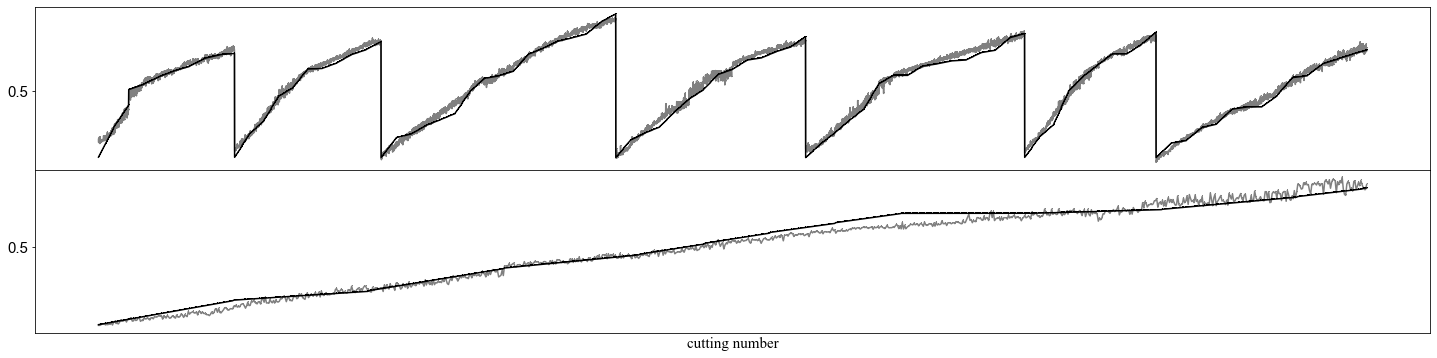

In [7]:
#
import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time

file_index = 8
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径

DOCUMENT_RESULT_PATH = 'results/comparation/feature engineering/'+str(file_index)+'/'
MODEL_LOAD_PATH = DOCUMENT_RESULT_PATH + '1_layer_concate_model.h5'
PHYSICINFOMED_SAVEPATH = DOCUMENT_RESULT_PATH + '1_layer_concate_result.npy'
    
load_flag = 1 ########################################1:重新加载模型，0：不加载##########################

if load_flag == 1:
    #信号层级关系
    SIGNAL_LENGTH_1 = 1536
    SIGNAL_LENGTH_2 = 64
    SIGNAL_LENGTH_3 = 8

    #输入数据
    INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
    INPUT_NUM = INPUT_SIZE[1]
    SCALE_NUM_FORCE = 3 #小波分解级数
    WAVELET_HIGHFREQ = 'db2'
    WAVELET_LOWFREQ = 'db6'
    # NOISE_FILTER_PERCENT = 90
    ATTENTION_RANGE = 24
    WEAR_SIZE = 1
    LIFE_SIZE = 1
    BATCH_SIZE = 64

    def wavelet_transform(data, scale_num):
        coeffs = np.arange(2).tolist()
        for j in range(np.shape(data)[2]):
            sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
            coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
            coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
            coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
            coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
    #         for i in range(1, scale_num+1):       #高频去噪
    #             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
            coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)

            if j == 0:
                coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
                coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
            else:
                coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
                coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
        return coeffs

    class lowhigh_freq_Attention(layers.Layer):
        # 将query，value和key拼接后输入，dot attention，便于timedistributed
        # https://blog.csdn.net/qq_37285386/article/details/101697758
        def __init__(self, **kwargs): #初始化方法
            super(lowhigh_freq_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
        def build(self, input_shape): #为Mylayer建立一个可训练的权重
            super(lowhigh_freq_Attention,self).build(input_shape)
        def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
            query = x[:, 0]
            query = tf.expand_dims(query, axis=1)
            value = x[:, 1:ATTENTION_RANGE+1]
            key = x[:, ATTENTION_RANGE+1:]
    #         print('query', np.shape(query), 'key', np.shape(key), 'value', np.shape(value))
            scores = tf.matmul(query, key, transpose_b=True)
    #         print('scores', np.shape(scores))
            distribution = tf.nn.softmax(scores, axis = 2)
    #         print('distribution', np.shape(distribution))
            value_weighted = tf.matmul(distribution, value)
    #         print('value_weighted1', np.shape(value_weighted))
            value_weighted = tf.reduce_sum(value_weighted, axis=1)
    #         print('value_weighted2', np.shape(value_weighted))
            attention_distribution = tf.squeeze(distribution)
    #         print('attention_distribution', np.shape(attention_distribution))
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape
    
    class temporal_Attention(layers.Layer):
        # 将query，value和key拼接后输入，dot attention，便于timedistributed
        # https://blog.csdn.net/qq_37285386/article/details/101697758
        def __init__(self, **kwargs): #初始化方法
            super(temporal_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
        def build(self, input_shape): #为Mylayer建立一个可训练的权重
            super(temporal_Attention,self).build(input_shape)
            self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
        def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
            key = x
            scores = tf.matmul(self.u_query, key, transpose_b=True)
            distribution = tf.nn.softmax(scores, axis = 2)
            value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
            attention_distribution = tf.squeeze(distribution)
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])#这里是自己手动计算出来的output_shape

    X_train_set=np.load(TRAINDATA_LOADPATH)
    Y_train_set = np.load(TRAINLABEL_LOADPATH)
    Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
    X_test_set=np.load(TESTDATA_LOADPATH)
    Y_test_set = np.load(TESTLABEL_LOADPATH)
    Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

    #validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
    X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
    Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]
    PHY_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
    X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
    Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]
    PHY_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]

    coeffs_train_force = wavelet_transform(X_train, SCALE_NUM_FORCE)
    coeffs_lowfreq_train = coeffs_train_force[0]
    coeffs_highfreq_train = coeffs_train_force[1]
    coeffs_test_force = wavelet_transform(X_test, SCALE_NUM_FORCE)
    coeffs_lowfreq_test = coeffs_test_force[0]
    coeffs_highfreq_test = coeffs_test_force[1]  

    ################################################### 模型读取及预测 ##################################################
    predictor = keras.models.load_model(MODEL_LOAD_PATH, custom_objects={'lowhigh_freq_Attention':lowhigh_freq_Attention, 
                                                                         'temporal_Attention':temporal_Attention})

################################################### 波形显示 ##################################################
fig_x = 15
fig_y = 6
size = 15
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
font1 = {'family':'Times New Roman', 'weight':'normal', 'size':size}

#train
wear_pre_train = predictor.predict([coeffs_lowfreq_train, coeffs_highfreq_train, PHY_train[:, :-1]], batch_size = BATCH_SIZE)
print('wear_pre_train', np.shape(wear_pre_train))

axis = np.linspace(1, np.shape(wear_pre_train)[0], np.shape(wear_pre_train)[0])
print('loss_train_avg', np.mean(np.square(wear_pre_train[:, 0] - Y_train)))
print('percent_train_avg', np.mean(np.abs(wear_pre_train[:, 0] - Y_train)/Y_train)*100, '%')
plt.figure(figsize=(25, 6))
plt.subplots_adjust(wspace=0, hspace=0)
plt.subplot(2,1,1)
plt.xticks([])  #去掉纵坐标值
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
plt.yticks([0.0, 0.5, 1], fontproperties = 'Times New Roman', size = size)   
plt.plot(axis, wear_pre_train[:, 0], marker = ',', color = 'gray')
plt.plot(axis, Y_train, marker = ',', color = 'black')

#test
time_start = time.time()
wear_pre_test = predictor.predict([coeffs_lowfreq_test, coeffs_highfreq_test, PHY_test[:, :-1]], batch_size = BATCH_SIZE)
print('time1 =  ', time.time()-time_start, 'sample_num', np.shape(coeffs_lowfreq_test)[0])

axis = np.linspace(1, np.shape(wear_pre_test)[0], np.shape(wear_pre_test)[0])
print('loss_test_avg', np.mean(np.square(wear_pre_test[:, 0] - Y_test)))
print('percent_test_avg', np.mean(np.abs(wear_pre_test[:, 0] - Y_test)/Y_test)*100, '%')
plt.subplot(2,1,2)
plt.xticks([])  #去掉纵坐标值
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
plt.yticks([0.0, 0.5, 1], fontproperties = 'Times New Roman', size = size)   
plt.plot(axis, wear_pre_test[:, 0], marker = ',', color = 'gray')
plt.plot(axis, Y_test, marker = ',', color = 'black')
# plt.savefig(DOCUMENT_RESULT_PATH + 'test_output.eps')
plt.show()

np.save(PHYSICINFOMED_SAVEPATH, wear_pre_test[:, 0])

## 结果展示

1
mAPE
dataDriven:  9.1169074177742 %
multiAtt:  8.925865590572357 %
layerAtt:  19.58591938018799 %
multiConcat:  29.684975743293762 %
layerConcat:  21.694226562976837 %
mFPE
dataDriven:  4.5101705 um
multiAtt:  4.2858663 um
layerAtt:  10.339419 um
multiConcat:  16.272305 um
layerConcat:  11.540373 um
MFPE
dataDriven:  26.237942 um
multiAtt:  9.412134 um
layerAtt:  20.825201 um
multiConcat:  20.701366 um
layerConcat:  19.967834 um


2
mAPE
dataDriven:  7.06934779882431 %
multiAtt:  7.1869537234306335 %
layerAtt:  4.118339344859123 %
multiConcat:  3.9487604051828384 %
layerConcat:  3.5586923360824585 %
mFPE
dataDriven:  2.8182201 um
multiAtt:  3.5562348 um
layerAtt:  1.8608024 um
multiConcat:  1.9115827 um
layerConcat:  1.7061577 um
MFPE
dataDriven:  18.611862 um
multiAtt:  8.744427 um
layerAtt:  6.20047 um
multiConcat:  5.785925 um
layerConcat:  5.951269 um


3
mAPE
dataDriven:  11.177603155374527 %
multiAtt:  6.900151818990707 %
layerAtt:  6.558580696582794 %
multiConcat:  8.212462812

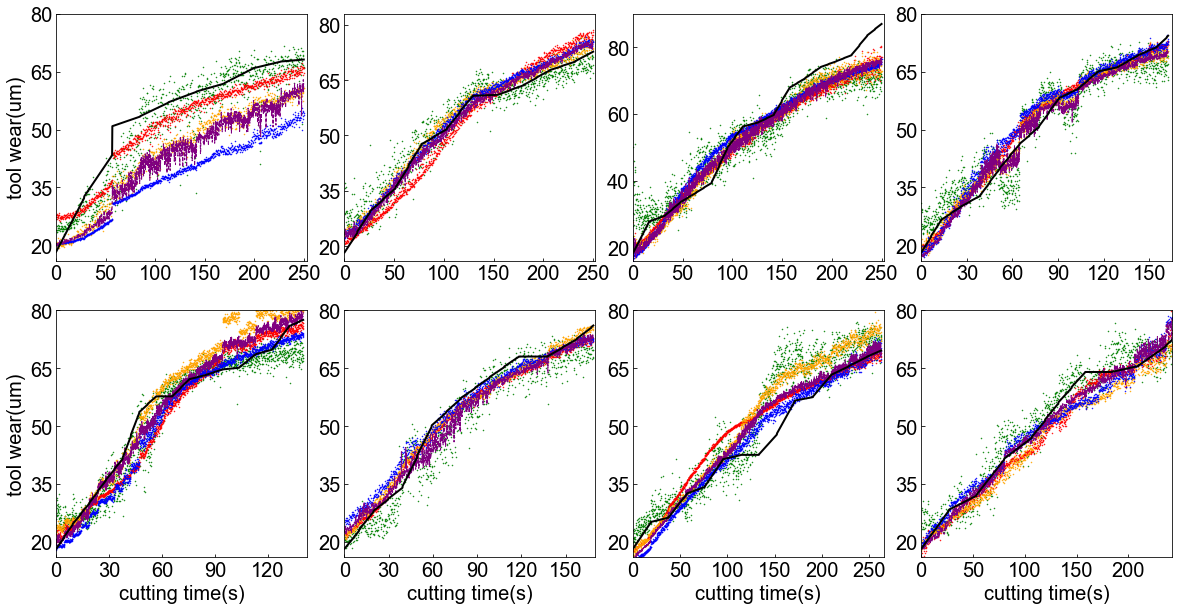

dataDriven: mAPE,  9.087842423468828 % mFPE 4.1362085044384 um MFPE 21.289151906967163 um
multiAtt: mAPE,  6.792930467054248 % mFPE 3.245173901319504 um MFPE 10.083177328109741 um
layerAtt: mAPE,  8.224354730919003 % mFPE 4.136251926422119 um MFPE 12.052914381027222 um
multiConcat: mAPE,  9.270732244476676 % mFPE 4.461547911167145 um MFPE 11.460155725479126 um
layerConcat: mAPE,  7.624584995210171 % mFPE 3.7787421345710754 um MFPE 10.444579839706421 um


In [8]:
#one_hot输出

import pywt
import numpy as np
import matplotlib.pyplot as plt
import xlrd

DATADRIVEN_LOADPATH = ['results/prediction/1/datadriven_result.npy', 'results/prediction/2/datadriven_result.npy',
                       'results/prediction/3/datadriven_result.npy', 'results/prediction/4/datadriven_result.npy',
                       'results/prediction/5/datadriven_result.npy', 'results/prediction/6/datadriven_result.npy', 
                       'results/prediction/7/datadriven_result.npy', 'results/prediction/8/datadriven_result.npy']
MULTI_ATTENTION_LOADPATH = ['results/comparation/loss function/1/compare_result.npy', 'results/comparation/loss function/2/compare_result.npy', 
                            'results/comparation/loss function/3/compare_result.npy', 'results/comparation/loss function/4/compare_result.npy', 
                            'results/comparation/loss function/5/compare_result.npy', 'results/comparation/loss function/6/compare_result.npy', 
                            'results/comparation/loss function/7/compare_result.npy', 'results/comparation/loss function/8/compare_result.npy']
LAYER_ATTENTION_LOADPATH = ['results/comparation/feature engineering/1/1_layer_attention_result.npy', 'results/comparation/feature engineering/2/1_layer_attention_result.npy',
                            'results/comparation/feature engineering/3/1_layer_attention_result.npy', 'results/comparation/feature engineering/4/1_layer_attention_result.npy',
                            'results/comparation/feature engineering/5/1_layer_attention_result.npy', 'results/comparation/feature engineering/6/1_layer_attention_result.npy', 
                            'results/comparation/feature engineering/7/1_layer_attention_result.npy', 'results/comparation/feature engineering/8/1_layer_attention_result.npy']
MULTI_CONCATE_LOADPATH = ['results/comparation/feature engineering/1/concate_result.npy', 'results/comparation/feature engineering/2/concate_result.npy',
                          'results/comparation/feature engineering/3/concate_result.npy', 'results/comparation/feature engineering/4/concate_result.npy',
                          'results/comparation/feature engineering/5/concate_result.npy', 'results/comparation/feature engineering/6/concate_result.npy', 
                          'results/comparation/feature engineering/7/concate_result.npy', 'results/comparation/feature engineering/8/concate_result.npy']
LAYER_CONCATE_LOADPATH = ['results/comparation/feature engineering/1/1_layer_concate_result.npy', 'results/comparation/feature engineering/2/1_layer_concate_result.npy',
                          'results/comparation/feature engineering/3/1_layer_concate_result.npy', 'results/comparation/feature engineering/4/1_layer_concate_result.npy',
                          'results/comparation/feature engineering/5/1_layer_concate_result.npy', 'results/comparation/feature engineering/6/1_layer_concate_result.npy', 
                          'results/comparation/feature engineering/7/1_layer_concate_result.npy', 'results/comparation/feature engineering/8/1_layer_concate_result.npy']

CONDITION_LOADPATH = 'tool_wear_2/milling_condition.xlsx'
LABEL_LOADPATH = ['dataset/dataset1/test_label1.npy', 'dataset/dataset2/test_label1.npy', 'dataset/dataset3/test_label1.npy', 
                  'dataset/dataset4/test_label1.npy', 'dataset/dataset5/test_label1.npy', 'dataset/dataset6/test_label1.npy', 
                  'dataset/dataset7/test_label1.npy', 'dataset/dataset8/test_label1.npy']
FIG_SAVEPATH = 'results/comparation/feature engineering/test_train_result.svg'
BATCH_SIZE = 64


CUTTING_TIME = [250, 250, 250, 162.5, 140, 168.75, 262.5, 250]
xlim = {'1': 253, '2': 252, '3': 252, '4': 165,
         '5': 142, '6': 170,'7': 265, '8': 242}
ylim = {'1': [16, 80], '2': [16, 83], '3': [16, 90], '4': [16, 80],
         '5': [16, 80], '6': [16, 80], '7': [16, 80], '8': [16, 80]}
xticks = {'1': [0, 50, 100, 150, 200, 250], '2': [0, 50, 100, 150, 200, 250],
         '3': [0, 50, 100, 150, 200, 250], '4': [0, 30, 60, 90, 120, 150],
         '5': [0, 30, 60, 90, 120, 150], '6': [0, 30, 60, 90, 120, 150],
         '7': [0, 50, 100, 150, 200, 250], '8': [0, 50, 100, 150, 200, 250]}
yticks = {'1': [20, 35, 50, 65, 80], '2': [20, 35, 50, 65, 80],
         '3': [20, 40, 60, 80, 100], '4': [20, 35, 50, 65, 80],
         '5': [20, 35, 50, 65, 80], '6': [20, 35, 50, 65, 80],
         '7': [20, 35, 50, 65, 80], '8': [20, 35, 50, 65, 80]}


def dataReading_sampleGenerating(condition_loadpath, num, index):
    samples_trian = []
    wear_train = []
    workbook = xlrd.open_workbook(condition_loadpath)
    sheet1 = workbook.sheet_by_index(0)         #用索引取第一个sheet
    v = np.array(sheet1.col_values(0, start_rowx=0, end_rowx=11)).astype('float32')
    f = np.array(sheet1.col_values(3, start_rowx=0, end_rowx=11)).astype('float32')
    time = np.linspace(0, CUTTING_TIME[index], num = num+1)[1:]
    v_feature = np.ones(np.shape(time)) * v[index]
    f_feature = np.ones(np.shape(time)) * f[index]
    samples_test = np.transpose([v_feature, f_feature, time])
    return samples_test

x_y_label_size = 20
x_y_stick_size = 20
font = {'family':'Arial', 'weight':'normal', 'size':20}
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.15, hspace=0.2)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

storage_list = np.zeros([8, 15])
for i in range(8):
    #磨损标签
    Y_test_set = np.load(LABEL_LOADPATH[i])
    Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]*1000
    
    dataDriven_result = np.load(DATADRIVEN_LOADPATH[i])*100
    multiAtt_result = np.load(MULTI_ATTENTION_LOADPATH[i])*100
    layerAtt_result = np.load(LAYER_ATTENTION_LOADPATH[i])*100
    multiConcat_result = np.load(MULTI_CONCATE_LOADPATH[i])*100
    layerConcat_result = np.load(LAYER_CONCATE_LOADPATH[i])*100

    axis = np.linspace(0, CUTTING_TIME[i], num=np.shape(Y_test)[0]+1)[1:]
    print(i+1)
    dataDriven = np.mean(np.abs((dataDriven_result - Y_test)/Y_test))*100
    multiAtt = np.mean(np.abs((multiAtt_result - Y_test)/Y_test))*100
    layerAtt = np.mean(np.abs((layerAtt_result - Y_test)/Y_test))*100
    multiConcat = np.mean(np.abs((multiConcat_result - Y_test)/Y_test))*100
    layerConcat = np.mean(np.abs((layerConcat_result - Y_test)/Y_test))*100
    storage_list[i, :5] = np.array([dataDriven, multiAtt, layerAtt, multiConcat, layerConcat])
    print('mAPE')
    print('dataDriven: ', dataDriven, '%')
    print('multiAtt: ', multiAtt, '%')
    print('layerAtt: ', layerAtt, '%')
    print('multiConcat: ', multiConcat, '%')
    print('layerConcat: ', layerConcat, '%')
    
    dataDriven = np.mean(np.abs(dataDriven_result - Y_test))
    multiAtt = np.mean(np.abs(multiAtt_result - Y_test))
    layerAtt = np.mean(np.abs(layerAtt_result - Y_test))
    multiConcat = np.mean(np.abs(multiConcat_result - Y_test))
    layerConcat = np.mean(np.abs(layerConcat_result - Y_test))
    storage_list[i, 5:10] = np.array([dataDriven, multiAtt, layerAtt, multiConcat, layerConcat])
    print('mFPE')
    print('dataDriven: ', dataDriven, 'um')
    print('multiAtt: ', multiAtt, 'um')
    print('layerAtt: ', layerAtt, 'um')
    print('multiConcat: ', multiConcat, 'um')
    print('layerConcat: ', layerConcat, 'um')
    
    dataDriven = np.max(np.abs(dataDriven_result - Y_test))
    multiAtt = np.max(np.abs(multiAtt_result - Y_test))
    layerAtt = np.max(np.abs(layerAtt_result - Y_test))
    multiConcat = np.max(np.abs(multiConcat_result - Y_test))
    layerConcat = np.max(np.abs(layerConcat_result - Y_test))
    storage_list[i, 10:15] = np.array([dataDriven, multiAtt, layerAtt, multiConcat, layerConcat])
    print('MFPE')
    print('dataDriven: ', dataDriven, 'um')
    print('multiAtt: ', multiAtt, 'um')
    print('layerAtt: ', layerAtt, 'um')
    print('multiConcat: ', multiConcat, 'um')
    print('layerConcat: ', layerConcat, 'um')
    print('\n')    

    plt.subplot(2,4,i+1)
    plt.plot(axis, dataDriven_result, '.', markersize=1, color='green', label = 'dataDriven')
    plt.plot(axis, multiAtt_result, '.', markersize=1, color='red', label = 'multiAtt')
    plt.plot(axis, layerAtt_result, '.', color='orange', markersize = 1, label = 'layerAtt')
    plt.plot(axis, multiConcat_result, '.', color='blue', markersize = 1, label = 'multiConcat')
    plt.plot(axis, layerConcat_result, '--', color='purple', linewidth = 1, label = 'layerConcat')
    plt.plot(axis, Y_test, color='black', linewidth = 2, label = 'actual wear')
    if i == 4 or i == 5 or i == 6 or i == 7:
        plt.xlabel('cutting time(s)', font)
    if i == 0 or i == 4:
        plt.ylabel('tool wear(um)', font)
    plt.tick_params(labelsize=x_y_label_size) #坐标及刻度设置
    plt.xticks(xticks[str(i+1)], fontproperties = 'Arial', size = x_y_stick_size)
    plt.yticks(yticks[str(i+1)], fontproperties = 'Arial', size = x_y_stick_size)
    plt.xlim(xmin=0, xmax=xlim[str(i+1)]), plt.ylim(ymin=ylim[str(i+1)][0], ymax=ylim[str(i+1)][1])
#     if i == 7:
#         plt.legend(prop = font)
plt.savefig(FIG_SAVEPATH, bbox_inches='tight')#无空白边界
plt.show()

averge_index = np.mean(storage_list, axis = 0)
print('dataDriven: mAPE, ', averge_index[0], '%', 'mFPE', averge_index[5], 'um', 'MFPE', averge_index[10], 'um')
print('multiAtt: mAPE, ', averge_index[1], '%', 'mFPE', averge_index[6], 'um', 'MFPE', averge_index[11], 'um')
print('layerAtt: mAPE, ', averge_index[2], '%', 'mFPE', averge_index[7], 'um', 'MFPE', averge_index[12], 'um')
print('multiConcat: mAPE, ', averge_index[3], '%', 'mFPE', averge_index[8], 'um', 'MFPE', averge_index[13], 'um')
print('layerConcat: mAPE, ', averge_index[4], '%', 'mFPE', averge_index[9], 'um', 'MFPE', averge_index[14], 'um')
